# Origins of path integration in CA1
Compare portions of time/distance cells vs place cells in light/dark environments, or tone vs no tone conditions

### TODO:
- Plot timecourse (LT1, LT2, LT3, toneLT1, toneLT2, toneLT3, seqLT1, seqLT2, etc), average for all animals
- Normalize per animal!
- Information content (AMI distribution) vs specific cell tuning (portion time cells, portion place cells, etc over time)

In [2]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('plot_style.mplstyle')

import yaml
import numpy as np
np.random.seed(42)
import pingouin as pg
import pandas as pd
import h5py
import os
from functions.signal_processing import smooth_1D
from tqdm import tqdm

# Params
with open('params.yaml','r') as file:
    params = yaml.full_load(file)

In [3]:
sessionList=os.listdir(os.path.join(params['path_to_results'],'tuning_data'))
data_list = [] # cell, animal,day,condition,AMI,pvalue
sessionList=os.listdir(os.path.join(params['path_to_results'],'tuning_data'))
for session in tqdm(sessionList):
    if os.path.exists(os.path.join(params['path_to_results'],'tuning_data',session,'info.yaml')): # TODO: Report any file missing
        info_file=open(os.path.join(params['path_to_results'],'tuning_data',session,'info.yaml'),'r')
        session_info = yaml.full_load(info_file)
        spatial_file = h5py.File(os.path.join(params['path_to_results'],'tuning_data',session,'spatial_tuning.h5'), 'r')
        temporal_file = h5py.File(os.path.join(params['path_to_results'],'tuning_data',session,'temporal_tuning.h5'), 'r')
        distance_file = h5py.File(os.path.join(params['path_to_results'],'tuning_data',session,'distance_tuning.h5'), 'r')
        direction_file = h5py.File(os.path.join(params['path_to_results'],'tuning_data',session,'direction_tuning.h5'), 'r')
        velocity_file = h5py.File(os.path.join(params['path_to_results'],'tuning_data',session,'velocity_tuning.h5'), 'r')

        for i in range(session_info['numNeurons']):
            data_list.append( #This will create one list entry per cell
                {
                    # Basic conditions
                    'subject':session_info['subject'],
                    'region':session_info['region'],
                    'day':session_info['day'],
                    'condition':session_info['condition'],
                    'task':session_info['task'],
                    'darkness':session_info['darkness'],
                    'optoStim':session_info['optoStim'],
                    'rewards':session_info['rewards'],
                    # Info metrics
                    'spatial_info':spatial_file['AMI'][i],
                    'temporal_info':temporal_file['AMI'][i],
                    'distance_info':distance_file['AMI'][i],
                    'velocity_info':velocity_file['AMI'][i],
                    'heading_info':direction_file['AMI'][i],
                    'spatial_pvalue':spatial_file['p_value'][i],
                    'temporal_pvalue':temporal_file['p_value'][i],
                    'distance_pvalue':distance_file['p_value'][i],
                    'velocity_pvalue':velocity_file['p_value'][i],
                    'heading_pvalue':direction_file['p_value'][i]
                }
            )
        
        # Close files
        info_file.close()
        temporal_file.close()
        spatial_file.close()
        distance_file.close()
        direction_file.close()
        velocity_file.close()

df = pd.DataFrame(data_list)

100%|██████████| 255/255 [00:22<00:00, 11.46it/s]


In [113]:
np.argsort(df.day)

0        21134
1        21085
2        21084
3        21083
4        21082
         ...  
53025    26468
53026    26469
53027    26470
53028    26502
53029    26514
Name: day, Length: 53030, dtype: int64

In [121]:
df.loc[df.subject==subject,'day']

0        20181109
1        20181109
2        20181109
3        20181109
4        20181109
           ...   
51682    20181122
51683    20181122
51684    20181122
51685    20181122
51686    20181122
Name: day, Length: 199, dtype: object

In [122]:
# For each subject, reset day count from 0
for subject in df.subject.unique():
    df.loc[df.subject==subject,'day'] = int(df.loc[df.subject==subject,'day'])-np.min(int(df.loc[df.subject==subject,'day']))


TypeError: cannot convert the series to <class 'int'>

In [53]:
## Create sub-data frames
CA1_df = df.query("region=='CA1' and rewards==True and condition=='normal'")

# Compare tone vs no tone linear track
tone_df = CA1_df.query("task=='legoLT' or task == 'legoSeqLT' and optoStim==False")

# Compare dark vs light conditions
dark_df = CA1_df.query("task=='legoLT'")

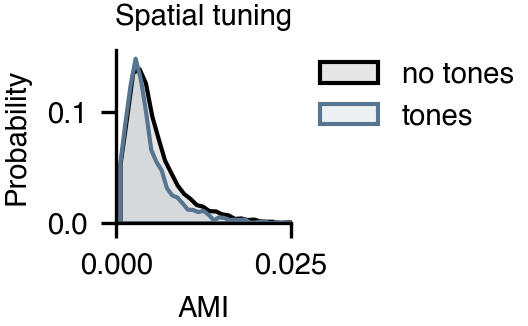

In [64]:
# Spatial coding with or without tones
plt.figure(figsize=(.75,.75))
sns.histplot(
             data=tone_df.query("task=='legoLT' and spatial_pvalue<.05"),
             x='spatial_info',
             bins=50,
             stat='probability',
             element='poly',
             alpha=.1,
             color='k',
             label='no tones')
sns.histplot(
             data=tone_df.query("task=='legoSeqLT' and spatial_pvalue<.05"),
             x='spatial_info',
             bins=50,
             stat='probability',
             element='poly',
             alpha=.1,
             color='C0',
             label='tones')
#plt.xscale('log')
plt.title('Spatial tuning')
plt.xlabel('AMI')
plt.xlim([0,.025])
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)
plt.savefig(os.path.join(params['path_to_results'],'figures', 'probhist_elapsed_spatial_noTone_vs_tone.pdf'))

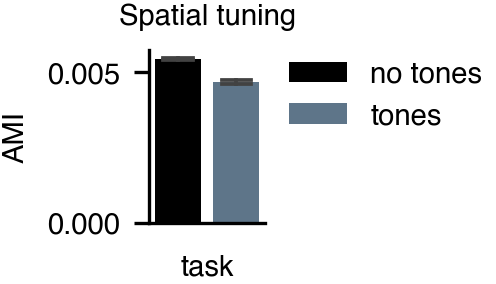

In [76]:
# Temporal coding with or without tones
plt.figure(figsize=(.5,.75))
sns.barplot(
            data=tone_df.query("spatial_pvalue<.05"),
            x='task',
            y='spatial_info',
            label=['no tones','tones'],
            errorbar='se',
            capsize=.5,
            palette=['k', 'C0']
            )
plt.title('Spatial tuning')
plt.ylabel('AMI')
plt.xticks([])
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)
plt.savefig(os.path.join(params['path_to_results'],'figures', 'bar_spatial_noTone_vs_tone.pdf'))

In [80]:
pg.ttest(x=tone_df.query("task=='legoLT' and spatial_pvalue<.05")['spatial_info'],
         y=tone_df.query("task=='legoSeqLT' and spatial_pvalue<.05")['spatial_info'])

/Users/guillaumeetter/.pyenv/versions/3.10.9/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/guillaumeetter/.pyenv/versions/3.10.9/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,10.378031,6241.728078,two-sided,4.983658e-25,"[0.0, 0.0]",0.180798,4.049e+21,1.0


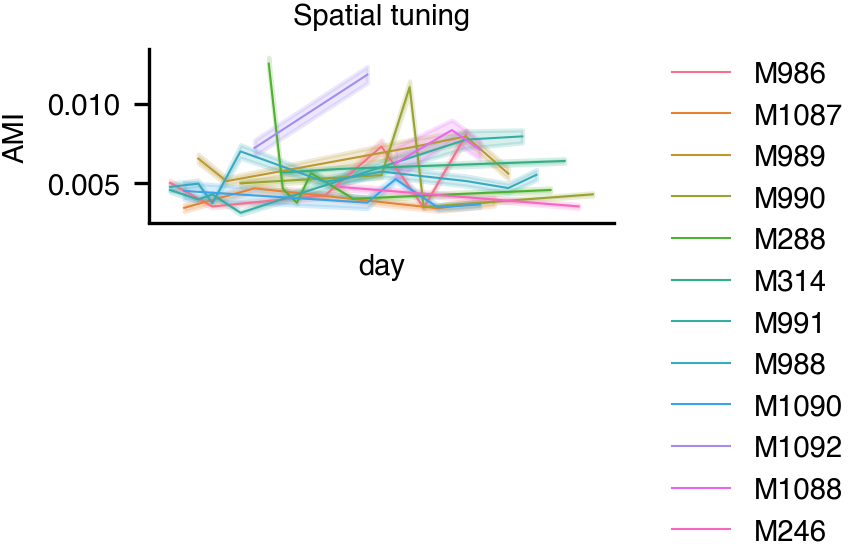

In [99]:
# Temporal coding with or without tones
plt.figure(figsize=(2,.75))
sns.lineplot(
            data=tone_df.query("spatial_pvalue<.05"),
            x='day',
            hue='subject',
            y='spatial_info',
            #label=['no tones','tones'],
            errorbar='se',
            #capsize=.5,
            #palette=['k', 'C0']
            )
plt.title('Spatial tuning')
plt.ylabel('AMI')
plt.xticks([])
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)
#plt.savefig(os.path.join(params['path_to_results'],'figures', 'lines_overDays_temporal_noTone_vs_tone.pdf'))